## Mutual Information Feature Selection

The aim of this notebook:
- Look at column features and how they influence a cell's self-exciting property (mutual info)

# Why conditional mutual information is larger than mutual information
The conditional variable has more possible states and therfore the join has a higher entropy - the maximum value it can take on can therefore be higher - to make plots easier to read we can normalize the mutual information with the mutual information of the target signal with itself.

$I(X;Y) = H(X) + H(Y) - H(X,Y)$


$I(X;Y|Z) = H(X,Z) + H(Y,Z) - H(X,Y,Z) - H(Z)$

# Interactive Plotly Plots

In [1]:
# from sparse_discrete_table import SparseDiscreteTable, build_discrete_table
from ipywidgets import widgets
import pandas as pd
import numpy as np

import plotly.graph_objs as go
import plotly.express as px
from utils.data_processing import time_series_to_time_index
from pprint import pprint
from sparse_discrete_table import quick_mutual_info, quick_cond_mutual_info
from sparse_discrete_table import mutual_info_over_time, conditional_mutual_info_over_time
from utils.interactive import filter_frame, get_total_counts, new_bins, new_int_bins
from utils.interactive import get_mean_map, bin_data_frame, State

pd.set_option('mode.chained_assignment', None)

`Just for reference where Crimes_Chicago_2001_to_2019_datetime_fmt came from:`
```python
# was used to convert original csv to dataframe and string dates to datetime format
df = pd.read_csv("data/original/Crimes_Chicago_2001_to_2019.csv")
df['Date'] = pd.DatetimeIndex(pd.to_datetime(df['Date']))
df = df[[
    'ID',
    'Date',
    'Primary Type',
    'Arrest',
    'Latitude',
    'Longitude',
]].dropna()
df.to_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl") # Dates are type datetime not string
```

In [2]:
from utils.data_processing import encode_category
from pandas.api.types import CategoricalDtype

df = pd.read_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl")

crime_categories = [
        "THEFT",
        "BATTERY",
        "CRIMINAL DAMAGE",
        "NARCOTICS",
        "ASSAULT",
        "BURGLARY",
        "MOTOR VEHICLE THEFT",
        "ROBBERY",
]

category_mask = df['Primary Type'].isin(crime_categories)

# used to remove the anomalies
LAT_MIN, LAT_MAX = 41.645, 42.022

LON_MIN, LON_MAX = -87.934, -87.525

FREQ = '168H' # '24H' # '1H' # '1W'

if FREQ == '24H':
    DATE_MIN, DATE_MAX = '2014-01-01', '2019-01-01'
elif FREQ == '1H':
    DATE_MIN, DATE_MAX = '2014-01-01', '2016-01-01'
elif FREQ == '1W' or FREQ == '168H':
    DATE_MIN, DATE_MAX = '2001-01-01', '2019-01-01'


lon_mask = (df.Longitude > LON_MIN) & (df.Longitude < LON_MAX)
lat_mask = (df.Latitude > LAT_MIN) & (df.Latitude < LAT_MAX)
date_mask = (df.Date >= DATE_MIN) & (df.Date < DATE_MAX)


df = df[lon_mask & lat_mask & date_mask & category_mask]

```python
pd.to_pickle(
    df,
    f"data/raw/crimes_{DATE_MIN}_{DATE_MAX}_min{LAT_MIN}{LON_MIN}_max{LAT_MAX}{LON_MAX}.pkl",
)
```

In [3]:
# Label encode the crime catgegories - makes histograms faster
# CrimeType = CategoricalDtype(categories=crime_categories, ordered=True)
# df['Primary Type'] = df['Primary Type'].astype(CrimeType)

# df['c'] = df['Primary Type'].cat.codes

df['t'] = time_series_to_time_index(t_series=df.Date, t_step=FREQ, floor=True)
df['c'] = encode_category(series=df['Primary Type'],categories=crime_categories)

In [4]:
# date selectors
date_range = pd.date_range(df.Date.min().ceil(FREQ), df.Date.max().floor(FREQ), freq=FREQ)

In [5]:
from utils.interactive import get_ratio_xy
    
ratio_xy = get_ratio_xy(df)

### Very important  - all the meta data is mapped from intervals of 0.001 in the lat and lon space with ratios of 8 and 11 to ensure that the grids cels are square

#### Confirm the make_grid technique and hist product the same output

In [242]:
# [20,16] - [10,8] - [5,4] - [3,2] - [1,1]
x_scale, y_scale = 15,12 # 10,8 #3,2
xy_scale = np.array([x_scale, y_scale])  # must be integer so that we can easily sample demographic data
dlon, dlat = xy_scale * np.array([0.001, 0.001])
meta_info = {}
meta_info["x_scale"] = x_scale
meta_info["y_scale"] = y_scale
meta_info["dlon"] = float(dlon)
meta_info["dlat"] = float(dlat)
meta_info["x in metres"] = 85000 * float(dlon)
meta_info["y in metres"] = 110000 * float(dlat)

pprint(meta_info)

# use perfect squares perfect squares

# all the meta data is mapped from intervals of 0.001 in 
# the lat and lon space with ratios of 8 and 11 to ensure that the grids cels are square

# cell_size_m = 430
# dlat = cell_size_m*lat_per_metre
# dlon = cell_size_m*lon_per_metre
 
# use increments of 0.001

{'dlat': 0.012,
 'dlon': 0.015,
 'x in metres': 1275.0,
 'x_scale': 15,
 'y in metres': 1320.0,
 'y_scale': 12}


In [243]:
from pprint import pformat        
        
def default_state():
    return  State(
        dlon=dlon,
        dlat=dlat,
        lon_max = LON_MAX,
        lon_min = LON_MIN,
        lat_max = LAT_MAX,
        lat_min = LAT_MIN,     
        total_lon_max = LON_MAX,
        total_lon_min = LON_MIN,
        total_lat_max = LAT_MAX,
        total_lat_min = LAT_MIN,         
        date_min = DATE_MIN,
        date_max = DATE_MAX,                
        time_index = 0,
        date_indices = (0,len(date_range)-1),
        date_range = pd.date_range(df.Date.min().ceil(FREQ), df.Date.max().floor(FREQ), freq=FREQ),
        freq=FREQ,
        crime_types = [*crime_categories],    
        mi_max_offset = 35,
        block_size_index=2,    
        conditional_temporal_variables= ["Day of Week"],# ["Hour", "Day of Week", "Time of Month", "Time of Year"],
        mutual_info_bins=10,
        log_norm=False,
    )
    
state = default_state()

In [245]:
state

{'block_size_index': 2,
 'callbacks': [],
 'conditional_temporal_variables': ['Day of Week'],
 'crime_types': ['THEFT',
                 'BATTERY',
                 'CRIMINAL DAMAGE',
                 'NARCOTICS',
                 'ASSAULT',
                 'BURGLARY',
                 'MOTOR VEHICLE THEFT',
                 'ROBBERY'],
 'date_indices': (0, 938),
 'date_max': '2019-01-01',
 'date_min': '2001-01-01',
 'date_range': DatetimeIndex(['2001-01-04', '2001-01-11', '2001-01-18', '2001-01-25',
               '2001-02-01', '2001-02-08', '2001-02-15', '2001-02-22',
               '2001-03-01', '2001-03-08',
               ...
               '2018-10-25', '2018-11-01', '2018-11-08', '2018-11-15',
               '2018-11-22', '2018-11-29', '2018-12-06', '2018-12-13',
               '2018-12-20', '2018-12-27'],
              dtype='datetime64[ns]', length=939, freq='168H'),
 'dlat': 0.012,
 'dlon': 0.015,
 'freq': '168H',
 'lat_max': 42.022,
 'lat_min': 41.645,
 'log_norm': False,
 

In [246]:
df

,ID,Date,Primary Type,Arrest,Latitude,Longitude,t,c
145304,11556487,2018-12-31 23:59:00,CRIMINAL DAMAGE,False,41.689079,-87.696064,939,2
145306,11552699,2018-12-31 23:57:00,CRIMINAL DAMAGE,False,41.740521,-87.647391,939,2
145307,11552724,2018-12-31 23:56:00,BATTERY,True,41.857068,-87.657625,939,1
145308,11552731,2018-12-31 23:55:00,BATTERY,False,41.751914,-87.647717,939,1
145309,11552715,2018-12-31 23:49:00,BATTERY,False,41.875684,-87.760479,939,1
...,...,...,...,...,...,...,...,...
6931226,2280620,2001-01-01 00:00:00,THEFT,False,41.806311,-87.674782,0,0
6931228,2353946,2001-01-01 00:00:00,THEFT,False,41.812451,-87.694479,0,0
6931232,2561460,2001-01-01 00:00:00,THEFT,False,41.919153,-87.636402,0,0
6931242,2613368,2001-01-01 00:00:00,THEFT,False,41.780623,-87.707393,0,0


`Reference for code to compare grids with previous generation techniques:`
```python
file_location = "data/processed/T24H-X425M-Y440M_2013-01-01_2017-01-01/"

generated_data = np.load(file_location + "generated_data.npz")
x_range = generated_data['x_range']
y_range = generated_data['y_range']
t_range = pd.read_pickle(file_location + "t_range.pkl")

crime_types_grids = generated_data['crime_types_grids'] 

xbins  = x_range - dlon/2
xbins = np.array([*xbins,xbins[-1]+dlon])

ybins  = y_range - dlat/2
ybins = np.array([*ybins,ybins[-1]+dlat])

import json

with open(file_location + "info.json", "r") as f:
    meta_info = json.load(f)
         
meta_info
```

### Widget Plot

In [247]:
# reset state
state.crime_types = [*crime_categories]

state.date_indices = (0,len(date_range)-1)
state.date_min, state.date_max = date_range[[*state.date_indices]]

state.date_range = pd.date_range(
    state.date_min.ceil(state.freq), 
    state.date_max.floor(state.freq), 
    freq=state.freq, 
)

tbins, cbins, ybins, xbins = new_bins(df, state)

In [248]:
font_dict = dict(
    family="Time New Roman",     
    size=14,
#     color="RebeccaPurple",
)

# quick plotly plot builders
def new_scatter(title, ylabel, xlabel, font_dict=None):
    return go.FigureWidget(
        data=go.Scatter(),
        layout=dict(
            title_text=title,
            title_x=0.5,        
            xaxis_title=xlabel,
            yaxis_title=ylabel,
            legend_title="Legend Title",
            font=font_dict,
        ),
    )


def new_heatmap(z):
    return go.Figure(
        data=go.Heatmap(z=z),
        layout=dict(
            height=600,
#             width=ratio_xy*fig_height,
            yaxis=dict(scaleanchor="x", scaleratio=1/ratio_xy),
        ),    
    )

In [249]:
fig_total_counts = new_scatter(title="Total Crimes",ylabel="Total Counts",xlabel="Date Time")

In [250]:
# MI Plots on a single curve
fig_mi_cmi = go.FigureWidget(
        data=[
            go.Scatter(
                name="$I(C_t;C_{t-k})$",#"Mutual Information",
            ),
            go.Scatter(
                name="$I(C_t;C_{t-k}|D_t)$", #"Condtional Mutual Information",
            ),
        ],
        layout=dict(
            title_text="Mutual and Condtional Mutual Information",
            title_x=0.5,        
            xaxis_title="Offest in days (k)",
            yaxis_title="Normalised Score [0,1]",
            legend_title="Curves",
#             font=font_dict,
        ),
    )

line_mi, line_cmi = fig_mi_cmi.data

In [251]:
counts_mean = get_mean_map(df, state)

In [252]:
scattergl = go.Scattergl(
    hoverinfo='skip',
    mode='markers',
    name='scattergl',
    marker_color='red',
)

heatmapgl = go.Heatmap(
    z=counts_mean,
    x=xbins,
    y=ybins, 
    hoverinfo='skip',
    colorscale='viridis',
    opacity=1,
    name='heatmapgl',
)


fig_height = 600
fig_app = go.FigureWidget(
    data=[heatmapgl, scattergl],
    layout=dict(
        margin={"r":50,"t":30,"l":0,"b":0},
        height=fig_height,
#         width=fig_height*ratio_xy,
        yaxis=dict(scaleanchor="x", scaleratio=1/ratio_xy),
        clickmode='event+select',
    ),
)

scattergl = fig_app.data[1]
heatmapgl = fig_app.data[0]

#### Update figures based on state

In [253]:
block_size_changed = True

In [254]:
from utils.utils import cut

In [255]:
def construct_temporal_information(
    date_range,
    temporal_variables=["Hour", "Day of Week", "Time of Month", "Time of Year"],
    month_divisions=4,
    year_divisions=4,
):
    df_dict = dict(Date=date_range)
    
    if "Hour" in temporal_variables:
        df_dict["Hour"] = date_range.hour
                
    if "Day of Week" in temporal_variables:
        df_dict["Day of Week"] = date_range.dayofweek

    if "Time of Month" in temporal_variables:
        df_dict["Time of Month"] = cut(date_range.day/date_range.days_in_month, month_divisions)

    if "Time of Year" in temporal_variables:
        df_dict["Time of Year"] = cut(date_range.dayofyear/(366), year_divisions)
    
    temp_info = pd.DataFrame(df_dict).set_index('Date')
    
    return temp_info

In [256]:
cond_var_map = {
    'Hour': 'H_t',
    'Day of Week': 'DoW_t',
    'Time of Month': 'ToM_t',
    'Time of Year': 'ToY_t',
}

def cmi_name(temporal_variables):
    return ",".join([cond_var_map[k] for k in temporal_variables])

cmi_name(state.conditional_temporal_variables)

'DoW_t'

In [257]:
if FREQ == '24H':
    cycles = 7,
elif FREQ == '1H':
    cycles = 7,7*24
elif FREQ == '168H' or '1W':
    cycles = 52
else:
    raise Exception(f"FREQ={FREQ} is not a valid value: 24H")

# global updater
def draw(state):  
    global block_size_changed
    if len(state.crime_types) == 0:
        return
    
    sub = filter_frame(df, state)
    sub_dt = date_range[sub.t.min():sub.t.max()+1]
    
    total_counts_y, total_counts_x = get_total_counts(sub, state, date_range)
  
    cycles = 1,
    conds = construct_temporal_information(
        date_range=sub_dt,
        temporal_variables=state.conditional_temporal_variables,
        month_divisions=10,
        year_divisions=10,
    ).values
    
    mi_y, mi_x = mutual_info_over_time(
        a=total_counts_y, 
        max_offset=state.mi_max_offset,
        norm=True, 
        log_norm=state.log_norm,
        include_self=False,
        bins=state.mutual_info_bins,
    )
    cmi_y, cmi_x = conditional_mutual_info_over_time(
        a=total_counts_y,
        max_offset=state.mi_max_offset,
        norm=True, 
        log_norm=state.log_norm,
        include_self=False,
        cycles=cycles,
        conds=conds,
        bins=state.mutual_info_bins,
    )
    
    slide = sub[sub.t == state.time_index]
    
    
    
    state.conditional_temporal_variables
    
    
    cond_names = cmi_name(state.conditional_temporal_variables)
    
    with fig_app.batch_update():
        if block_size_changed:
            mean_map, xbins, ybins = get_mean_map(df, state)
            block_size_changed = False
            
            heatmapgl.x = xbins
            heatmapgl.y = ybins
            heatmapgl.z = mean_map
        
        
        scattergl.x=slide.Longitude
        scattergl.y=slide.Latitude
        
        fig_total_counts.data[0].x = total_counts_x
        fig_total_counts.data[0].y = total_counts_y
        
        line_mi.x = mi_x
        line_mi.y = mi_y
        
        line_cmi.x = cmi_x
        line_cmi.y = cmi_y
        
        line_cmi.name=f"$I(C_t;C_{{t-k}}|{cond_names})$"
        
        
        fig_mi_cmi.update_layout(
            title_text=f"Mutual and Condtional Mutual Information\ncondtioned on {state.conditional_temporal_variables}")

In [258]:
def scattergl_on_select(trace,points,selector):
    global lat_filter, lon_filter
    if trace.name == 'scattergl':                
        state.lon_min, state.lon_max = selector.xrange
        state.lat_min, state.lat_max = selector.yrange
        
        draw(state)
            
scattergl.on_selection(scattergl_on_select)

In [259]:
# widget setup
from ipywidgets import Layout, widgets

# helper functions
def get_widget_index(change):
    if isinstance(change, dict) and change.get('name') == 'index':
        return change.get('new')
    return None

def get_widget_value(change):
    if isinstance(change, dict) and change.get('name') == 'value':
        return change.get('new')
    return None

#### Widgets and how they should update state

In [260]:
# time index date display label
current_date_label = widgets.Label(f'Date: {date_range[state.time_index].strftime("%c")}')

# time index selector
time_index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(date_range)-1,
    step=1,
    description='Time Index:',
    continuous_update=False,
    layout=Layout(width='80%'),
)

def on_change_time_index(change):
    global current_date_label, state
    time_index = get_widget_value(change)
    if time_index is not None:
        current_date_label.value = f'Date: {date_range[time_index].strftime("%c")}'
        state.time_index = time_index
        draw(state)
        
time_index_slider.observe(on_change_time_index)

play_button = widgets.Play(
    value=0,
    min=time_index_slider.min,
    max=time_index_slider.max,
    step=1,
    interval=800,
    description="Press play",
    disabled=False
)
widgets.jslink((play_button, 'value'), (time_index_slider, 'value'))


# Date Slider
date_range_slider = widgets.SelectionRangeSlider(
    options=[d.strftime('%y/%m/%d') for d in date_range],
    index=(0, len(date_range)-1),
    description='Date Range:',
    disabled=False,
    orientation = 'horizontal',
    layout=Layout(width='95%'),
    continuous_update=False,
)

def on_change_date_range_slider(change):
    global state, time_index_slider
    
    index = get_widget_index(change)
    if index is not None:        
        i, j = index
        
        time_index_slider.value = i 
        time_index_slider.min = i
        time_index_slider.max = j
                
        state.update(
            date_range_indices=(i,j),  
            date_min=date_range[i],
            date_max=date_range[j],        
        )
        draw(state)

date_range_slider.observe(on_change_date_range_slider)


# crime type selector
def on_change_crime_types(button):
    global state
    if button.button_style == "":
        button.button_style = "success"
        state.crime_types.append(button.description)
    else:
        button.button_style = ""
        state.crime_types.remove(button.description)
        
    
    draw(state)
    
def new_buttons(names,all_selected=False):
    global state
    buttons = []
    
    if all_selected:
        state.crime_types = [*names]
        button_style = "success"
    else:
        state.crime_types = []
        button_style = ""
        
    for name in names:
        button = widgets.Button(
            description=name,
            tooltip=name,
            disabled=False,
            button_style=button_style, # 'success', 'info', 'warning', 'danger' or ''
        )
        
        button.on_click(on_change_crime_types)
        
        buttons.append(button)
    return buttons
    
    
time_selectors = widgets.VBox([
    widgets.HBox([date_range_slider]),
    widgets.HBox([time_index_slider])    
])    

buttons = new_buttons(names=crime_categories, all_selected=True)
crime_selectors = widgets.VBox([
    widgets.HBox(buttons[:4]),
    widgets.HBox(buttons[4:]),
])

# Spatial block size selection widget
dlon_dlat_opts = list(map(tuple,(
    np.array([[40,32], [20,16],[15,12],[10,8], [5,4], [3,2], [1,1]]) * np.array([0.001, 0.001]))))
dx_dly_opts = list(map(tuple,(
    np.array([[40,32], [20,16],[15,12],[10,8], [5,4], [3,2], [1,1]]) * np.array([85, 110]))))

dropdown_block_size = widgets.Dropdown(
    options=[(v, i) for i,v in enumerate(dx_dly_opts)],
    value=state.block_size_index,
    description='dx, dy:',
    disabled=False,
)

def on_change_dropdown_block_size(change):
    global state, block_size_changed
    value = get_widget_value(change)
    if value is not None:  
        state.block_size_index = value
        state.dlon, state.dlat = dlon_dlat_opts[value]
        block_size_changed = True
        draw(state)
        
dropdown_block_size.observe(on_change_dropdown_block_size)


# widgets combinations and setup
row0 = widgets.HBox([play_button, crime_selectors, dropdown_block_size])
row1 = time_selectors

controller = widgets.VBox([row0, row1, current_date_label])

In [265]:
# state.conditional_temporal_variables = ["Hour", "Day of Week", "Time of Month", "Time of Year"]
state.conditional_temporal_variables = [ "Time of Month", "Time of Year"]
# state.conditional_temporal_variables = ["Day of Week"]

In [266]:
from utils.data_processing import sincos_vector

In [268]:
state.mi_max_offset = 5
state.mutual_info_bins = 10
state.log_norm = False
draw(state)
widgets.VBox([fig_mi_cmi, fig_total_counts, controller, fig_app])

    'data': [{'name': '$I(C_t;C_{t-k})$',
              'type': 'scatter',
     …

In [269]:
from utils.interactive import state_to_conf
state_to_conf(state)

{'start_date': '2001-01-04',
 'end_date': '2019-01-03',
 'dT': '168H',
 'x_scale': 15,
 'y_scale': 12,
 'lat_max': 42.022,
 'lat_min': 41.645,
 'lon_max': -87.525,
 'lon_min': -87.934,
 'root': './',
 'crime_types': ['BURGLARY']}

### Save selected subset limits to json file to be generated at later stage

In [270]:
from datetime import datetime
from utils.interactive import state_to_conf
from utils.utils import write_json

SAVE_SELECTION = True
if SAVE_SELECTION:
    conf = state_to_conf(state)
#     ref = datetime.now().isoformat().split('.')[0]
    ref = hex((hash(conf.__repr__()) % 3000) + 300).split('x')[1]
    
    print(f"Saving file with ref: {ref}")
    write_json(
        data=conf,
        file_name=f"./config/generate_data_{ref}.json",
    )

Saving file with ref: 1f1


### Statistics on selection

In [154]:
sub = filter_frame(df, state)
print(f"Number of crime occurences: {len(sub)}")

binned_data, (tbins_sub, cbins_sub, ybins_sub, xbins_sub) = bin_data_frame(sub, state)

sub_dt = date_range[sub.t.min():sub.t.max()+1]
counts_sum = binned_data.sum(-1).sum(-1)

assert len(counts_sum) == len(sub_dt)

Number of crime occurences: 1042640


In [155]:
from utils.preprocessing import scale_per_time_slot

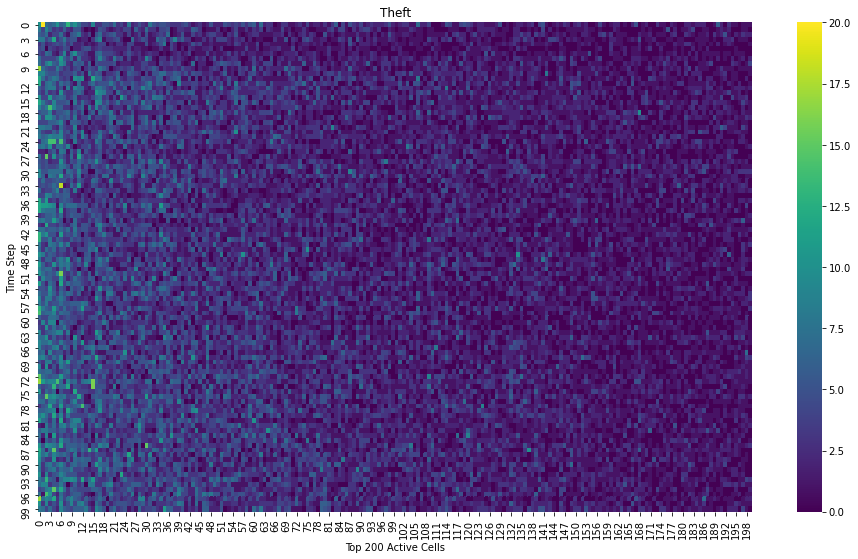

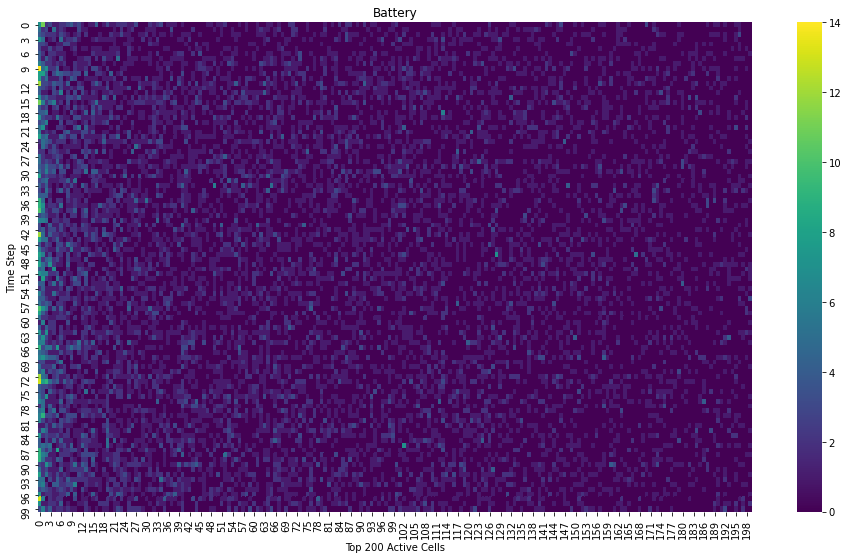

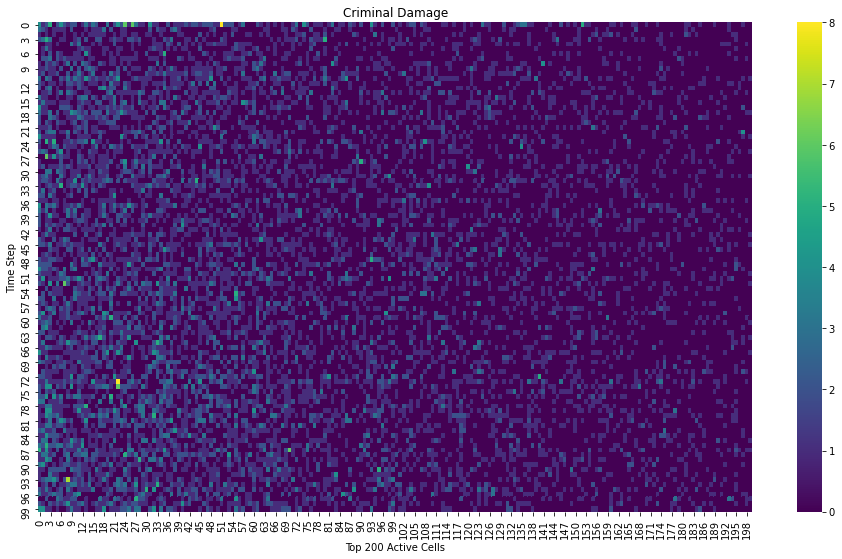

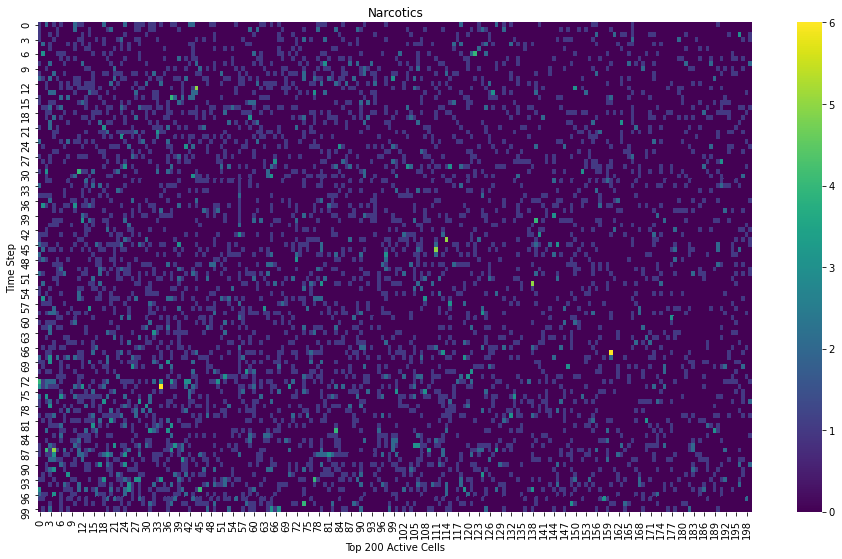

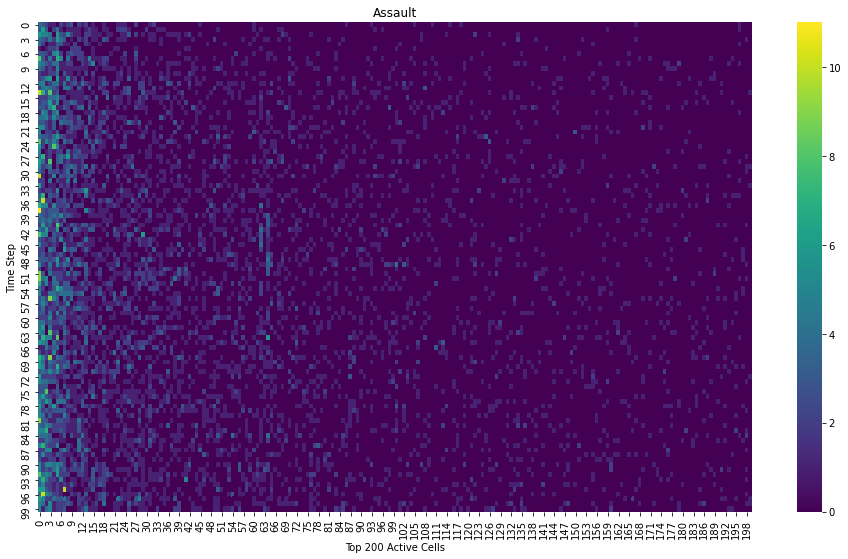

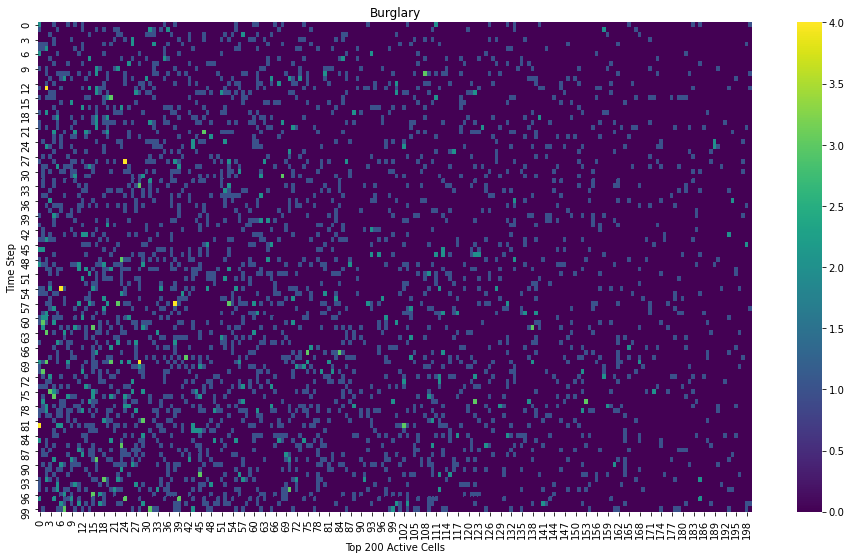

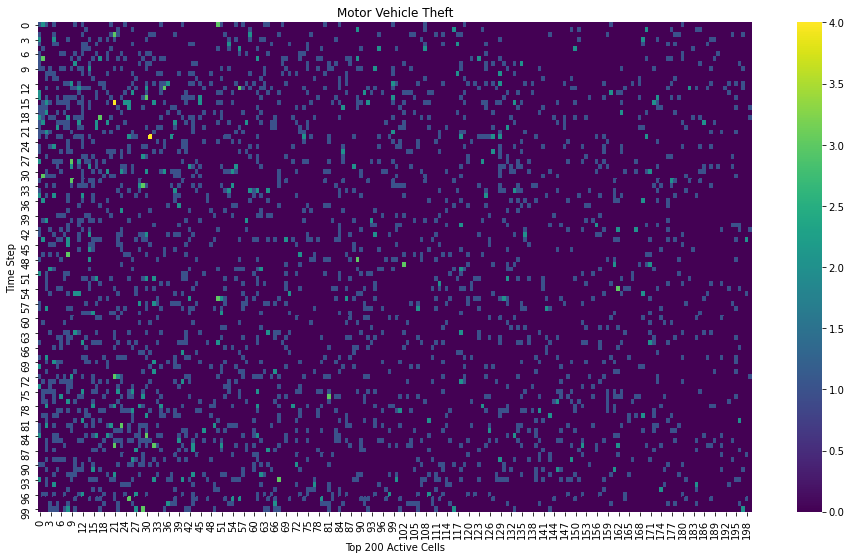

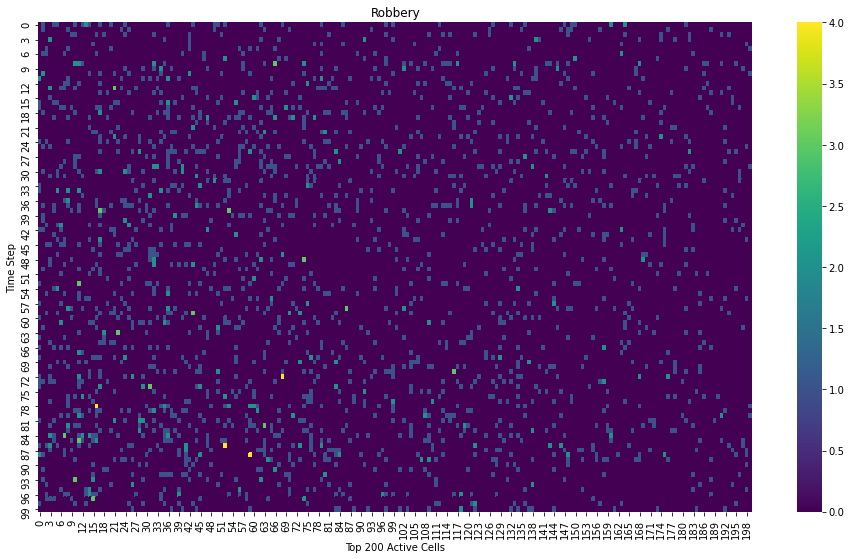

In [156]:
grids = np.concatenate([np.sum(binned_data, axis=1, keepdims=True), binned_data], axis=1)
assert (grids[:,1:] == binned_data).all() == True
assert (grids[:,0:1] == np.sum(binned_data, axis=1, keepdims=True)).all() == True

from utils.preprocessing import Shaper

shaper = Shaper(grids)
sqz = shaper.squeeze(grids)

# from utils.plots import im_sns

# args = np.argsort(sqz.sum(0).sum(0))[::-1]


topn = 200
for i,k in enumerate(state.crime_types):
    args = np.argsort(sqz[:,i].sum(0))[::-1][:topn]
    sqz_over_time = sqz[:100,i,args]
    
    im_sns(sqz_over_time,title=k.title(), figsize=(16,9),
           xlabel=f'Top {topn} Active Cells',
           ylabel='Time Step')

In [157]:
from utils.interactive import InteractiveHeatmapsWithLines

grid_dict = dict()
grid_dict['Total'] = np.sum(binned_data, axis=1)
for i,k in enumerate(state.crime_types):
    grid_dict[k.title()] = binned_data[:,i]

InteractiveHeatmapsWithLines(
    date_range=sub_dt, 
    col_wrap=3,
    **grid_dict,
).app

In [34]:
# np.concatenate([total_counts_by_type,pd.DataFrame({"Date":sub_dt})],axis=1)
pd.DataFrame({"Date":sub_dt})
# total_counts_by_type

,Date
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
1821,2018-12-27
1822,2018-12-28
1823,2018-12-29
1824,2018-12-30


In [69]:
construct_temporal_information


data_dict = {k: counts_sum[:,i]   for i,k in enumerate(state.crime_types)}
# data_dict['Date'] = sub_dt
# data_dict['Hour'] = sub_dt.hour
# data_dict['Weekday'] = sub_dt.dayofweek

total_counts_by_type = pd.DataFrame(data_dict)
total_counts_by_type

### 2D Histogram

In [68]:
# display distribution of a sample of the data
fig_height=800
px.density_heatmap(
    data_frame=sub, #.sample(10000),
    x="Longitude",
    y="Latitude", 
    marginal_x="histogram",
    marginal_y="histogram",
    height=fig_height,
    width=ratio_xy*fig_height,
    nbinsx=len(xbins_sub),
    nbinsy=len(ybins_sub),
)

### Scikit MI-regression vs Our MI-discrete table

In [37]:
from utils.utils import cut

In [67]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

series = counts_sum.sum(-1)

# series = cut(series, 10)
# series = np.round(np.log2(1 + series))

max_offset = 370
n = len(series) - max_offset
l = []
for i in range(max_offset+1):
    l.append(series[i:n+i])
data = np.array(l).T    

X, y = data[:,:], data[:,-1]    

mi = mutual_info_classif(X,y,discrete_features=True)
mi_rest, mi_max = mi[:-1], mi[-1]
mi_clf = (mi_rest/mi_max)[::-1]

mi = mutual_info_regression(X,y,discrete_features=True)
mi_rest, mi_max = mi[:-1], mi[-1]
mi_reg = (mi_rest/mi_max)[::-1]


shape_ = data.shape
data = cut(data.flatten(),10).reshape(shape_)

X, y = data[:,:], data[:,-1]   

mis = []
for i in range(max_offset+1):
    mis.append(quick_mutual_info(X[:,i], y,norm=True))
mi_rest, mi_max = mis[:-1], mis[-1]
mi_our = (mi_rest/mi_max)[::-1]


px.line(pd.DataFrame({"mi_our":mi_our, "mi_reg":mi_reg, "mi_clf": mi_clf}))

### 2D decomposition of the signals by crime type

In [51]:
traces = []

for i,k in enumerate(state.crime_types):
    trace = go.Scatter(
        x=sub_dt,
        y=counts_sum[:,i], 
        mode='lines',
        name=k,
        opacity=0.5,
    )
    traces.append(trace)
    
trace = go.Scatter(
    x=sub_dt,
    y=counts_sum.sum(1),
    mode='lines',
    name='TOTAL',
    opacity=0.1,
)
traces.append(trace)
    
fig = go.Figure(traces)

fig.update_layout(
    width=900,
    height=700,
)

fig.show()

### 3D decomposition of the signals by crime type

In [52]:
traces = []

for i,k in enumerate(state.crime_types):
    trace = go.Scatter3d(
        x=sub_dt,
        y=np.ones(len(counts_sum))*(i+1),
        z=counts_sum[:,i], 
        mode='lines',
        name=k,
        opacity=0.5,
    )
    traces.append(trace)
    
trace = go.Scatter3d(
    x=sub_dt,
    y=np.ones(len(counts_sum))*0,
    z=counts_sum.sum(1),
    mode='lines',
    name='TOTAL',
    opacity=0.1,
)
traces.append(trace)
    
fig = go.Figure(traces)

fig.update_layout(
    width=900,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

### Distribution Counts by Crime Type

In [53]:
# counts_sum = np.round(np.log2(1 + counts_sum))

# cap = 33
# counts_sum[counts_sum > cap] = cap

traces = []
traces.append(
    go.Histogram(
        x=counts_sum.sum(1),
        name='TOTAL',
        opacity=0.4,
        histnorm='probability density',
    ),
)


for i,k in enumerate(state.crime_types):
    traces.append(
        go.Histogram(
            x=counts_sum[:,i],
            name=k,
            opacity=0.4,
            histnorm='probability density',
        ),
    )
    
fig = go.Figure(traces, layout=dict(height=600, title="Crime Count Distribution by Type"))
fig.update_layout(
    barmode='overlay', 
    title_x=0.5,
    yaxis_title="Probability",
    xaxis_title="Count",
)
fig.show()

In [59]:
data_dict = {k: counts_sum[:,i]   for i,k in enumerate(state.crime_types)}
# data_dict['Date'] = sub_dt
# data_dict['Hour'] = sub_dt.hour
# data_dict['Weekday'] = sub_dt.dayofweek

total_counts_by_type = pd.DataFrame(data_dict)
total_counts_by_type

In [57]:
# distribution of selection counts
fig = px.histogram(
    total_counts_by_type.melt(),
    histnorm='probability density',
    title="Crime Count Distribution by Type",
#     color="variable",
    facet_col="variable",
    facet_col_wrap=1,
    opacity=.3,
)

fig.update_layout(barmode='overlay', height=1200, width=300, showlegend=False)
fig.update_layout(title={'x':0.5})
fig.update_yaxes(title_text='Probability')
fig.update_xaxes(title_text='Crime Count')
fig.show()

In [55]:
total_counts_y, total_counts_x = get_total_counts(sub, state, date_range)
fig = px.histogram(pd.DataFrame({"Crime Count":total_counts_y}),
             histnorm='probability density',title="Crime Count Distribution")
fig.update_layout(title={'x':0.5})
fig.update_yaxes(title_text='Probability')
fig.update_xaxes(title_text='Crime Count')
fig.show()

In [54]:
sub_dow_name = pd.DataFrame({'day of week name': sub.Date.dt.day_name()})
sub_dow = pd.DataFrame({'day of week': sub.Date.dt.dayofweek})
sub_hour = pd.DataFrame({'hour of day': sub.Date.dt.hour})
sub_cat = pd.concat([sub, sub_dow, sub_dow_name, sub_hour], axis=1)
sub_cat['crimes'] = np.ones(len(sub))


# distribution of selection counts
total_counts_y, total_counts_x = get_total_counts(sub, state, date_range)

fig = px.histogram(pd.DataFrame({"Crime Counts":total_counts_y}),
             histnorm='probability density',title="Crime Count Distribution")
fig.update_yaxes(title_text='Probability')
fig.update_xaxes(title_text='Crime Count')
fig.update_layout(title={'x':0.5})
fig.show()

# log normed distribution
log_scaled_counts_y = np.round(np.log2(1+ total_counts_y))
fig = px.histogram(pd.DataFrame({"Log Scaled Crime Counts":log_scaled_counts_y}),
             histnorm='probability density',title="Log Crime Count Distribution log2(1+x)")
fig.update_yaxes(title_text='Probability')
fig.update_xaxes(title_text='Log Crime Count')
fig.update_layout(title={'x':0.5})
fig.show()

# distribution of crime type
fig = px.histogram(
    data_frame=sub_cat,
    x='Primary Type',
    y='crimes', 
    histnorm='probability density',
    title="Crime Type Distribution",
)
fig.update_layout(title={'x':0.5})
fig.update_yaxes(title_text='Probability')
fig.update_xaxes(title_text='Crime Count')
fig.show()


# crime distirbution distribution of hour of day by type
fig = px.histogram(
    data_frame=sub_cat,
    x='hour of day',
    y='crimes', 
    facet_col='Primary Type',
    facet_col_wrap=2,
    height=800,
    histnorm='probability density',
    title="Crime Type Distribution by Hour",
)
fig.update_layout(title={'x':0.5})
fig.update_yaxes(title_text='Probability',col=1)
fig.update_xaxes(title_text='Hour of Day')
fig.show()

# distribution of day of week
fig = px.histogram(
    data_frame=sub_cat,
    x='day of week',
    y='crimes', 
    facet_col='Primary Type',
    facet_col_wrap=2,
    height=800,
    histnorm='probability density',
    title="Crime Type Distribution by Weekday",
)
fig.update_layout(title={'x':0.5})
fig.update_yaxes(title_text='Probability',col=1)
fig.update_xaxes(
    title_text='Day of Week',
    tickmode = 'array',
    tickvals = [0,1,2,3,4,5,6],
    ticktext = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],    
)

fig.show()

In [53]:
# binned_data, bins = bin_data_frame(df,state)
mean_map, xbins, ybins = counts_mean = get_mean_map(df, state)
new_heatmap(z=mean_map)

### Geo-plots

In [160]:
mapbox_access_token = open(".mapbox_token").read()
# mapbox_access_token = "open-street-map"
mapbox_access_token

on_state = ('#f050ae', 8)
off_state = ('#ffab00', 8)

mapbox_styles = {
    "sat": "mapbox://styles/bernsblack/ckecz0wr52pfc1at7tvu43fmj", 
    "mono": "mapbox://styles/bernsblack/ckecyyizy065w19psrikmeo5d",
    "dark": "mapbox://styles/bernsblack/ckeikbchd254619s57np6iyum",
}

color_palette = ["#33a8c7","#52e3e1","#a0e426","#fdf148","#ffab00","#f77976","#f050ae","#d883ff","#9336fd"]

In [161]:
from utils.plots import hist2d_to_geo
# get block infos for whole df

sub = filter_frame(df,state).sample(10_000)

binned_data, (tbins,cbins,ybins,xbins) = bin_data_frame(sub,state)
 
counts_sum = binned_data.sum(0).sum(0)
counts_mean = binned_data.mean(0).mean(0)

blocks_geo, blocks_info = hist2d_to_geo(counts_mean,xbins,ybins,filter_zero=True)

heatmap_geo = go.Choroplethmapbox(
    geojson=blocks_geo,
    locations=blocks_info.id,
    z=blocks_info.value,
    colorscale="Viridis",
    zmin=blocks_info.value.min(),
    zmax=blocks_info.value.max(),
    marker_opacity=0.5,
    marker_line_width=0,
    name='heatmap',
    hoverinfo='text',
    hovertext=blocks_info[['y','x','value']],
)

# scatter_geo = go.Scattermapbox(
#     lon=sub.Longitude,
#     lat=sub.Latitude,
#     opacity=.4,
#     hoverinfo='skip',
#     name='scatter',
# )

scatter_geo = []
for cat in crime_categories:
    tmp = sub[sub["Primary Type"] == cat]
    scatter = go.Scattermapbox(
        lon=tmp.Longitude,
        lat=tmp.Latitude,
        opacity=.4,
        hoverinfo='skip',
        name=cat,
    )
    scatter_geo.append(scatter)
    
    

fig_geo = go.FigureWidget(data=[heatmap_geo, *scatter_geo])

fig_geo.update_layout(
    clickmode='event+select',
    mapbox_style=mapbox_styles["sat"],
    mapbox_accesstoken=mapbox_access_token,
    mapbox_zoom=10,
    mapbox_center = {"lat": np.mean(ybins), "lon": np.mean(xbins)},
    margin={"r":0,"t":30,"l":0,"b":10},
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
    ),
)

heatmap_geo = fig_geo.data[0]  

# def heatmap_geo_on_select(trace,points,selector):
#     global state
    
#     inds = points.point_inds
#     selection = blocks_info.iloc[inds]
#     _,_,f_x_min,f_y_min = selection.min()
#     _,_,f_x_max,f_y_max = selection.max()

#     state.lon_min, state.lon_max = xbins[[f_x_min,f_x_max]]
#     state.lat_min, state.lat_max = ybins[[f_y_min,f_y_max]]
    
      
# heatmap_geo.on_selection(heatmap_geo_on_select)

fig_geo

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …